In [1]:
#SegNet
#SegNet
#SegNet

In [4]:
import numpy as np
from keras.models import save_model, load_model, Model
from keras.layers import Input, Dropout, BatchNormalization, LeakyReLU, concatenate
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose
import h5py 
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Add
from keras.applications import VGG16
from keras import layers, models

In [3]:
fh5 = h5py.File(r'../data/PolypGen+CVCtrain_imgandmasks.h5','r')
img_png_x = fh5['img']
img_png_x = np.array(img_png_x)
mask_x = fh5['masks']
mask_x = np.array(mask_x)

In [10]:
mask_x  = mask_x .reshape(len(mask_x), 288, 384, 1)
mask_x = mask_x/255
mask_x .shape

(2987, 288, 384, 1)

In [11]:
img_png_x.max()

1.0

In [12]:
mask_x.max()

1.0

In [13]:
# -----------------------------------------------------------------
# 从txt文件读取并恢复为NumPy数组
# -----------------------------------------------------------------
# 读取训练集
# Train = np.loadtxt('E:\wujieyu\img train PolypGen+CVC\Train.txt', dtype=int)
Train = np.loadtxt('../Train.txt', dtype=int)
# 读取验证集
# Val = np.loadtxt('E:\wujieyu\img train PolypGen+CVC\Val.txt', dtype=int)
Val = np.loadtxt('../Val.txt', dtype=int)

In [14]:
# -----------------------------------------------------------------
# 按索引划分图像数据
# -----------------------------------------------------------------
# 划分训练集（T_img_png_x）和验证集（V_img）
T_img = img_png_x[Train]
V_img = img_png_x[Val]
T_mask = mask_x[Train]
V_mask = mask_x[Val]

In [15]:
print(  T_img.shape,
        V_img.shape,
        T_mask.shape,
        V_mask.shape)

(2390, 288, 384, 3) (597, 288, 384, 3) (2390, 288, 384, 1) (597, 288, 384, 1)


In [5]:
def SegNet(input_shape=(224,224,3), n_classes=1):
    inputs = layers.Input(shape=input_shape)

    # ---------- Encoder ----------
    # Block 1
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    p1 = layers.MaxPooling2D((2,2))(x)

    # Block 2
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(p1)
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    p2 = layers.MaxPooling2D((2,2))(x)

    # Block 3
    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(p2)
    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    p3 = layers.MaxPooling2D((2,2))(x)

    # Block 4
    x = layers.Conv2D(512, (3,3), padding="same", activation="relu")(p3)
    x = layers.Conv2D(512, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3,3), padding="same", activation="relu")(x)
    p4 = layers.MaxPooling2D((2,2))(x)

    # Block 5
    x = layers.Conv2D(512, (3,3), padding="same", activation="relu")(p4)
    x = layers.Conv2D(512, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3,3), padding="same", activation="relu")(x)
    p5 = layers.MaxPooling2D((2,2))(x)

    # ---------- Decoder ----------
    # Block 5D
    x = layers.UpSampling2D((2,2))(p5)
    x = layers.Conv2D(512, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3,3), padding="same", activation="relu")(x)

    # Block 4D
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(512, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(512, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)

    # Block 3D
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)

    # Block 2D
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)

    # Block 1D
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)

    # 输出层
    outputs = layers.Conv2D(n_classes, (1,1), activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# ---------- 创建模型 ----------
model = SegNet(input_shape=(288,384,3), n_classes=1)
model.summary()


2025-08-26 22:35:22.619269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79181 MB memory:  -> device: 0, name: NVIDIA A800 80GB PCIe, pci bus id: 0000:98:00.0, compute capability: 8.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 288, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 288, 384, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 288, 384, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 144, 192, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 144, 192, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 144, 192, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 72, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 96, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 96, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 72, 96, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 36, 48, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 36, 48, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 36, 48, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 36, 48, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 18, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 18, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 18, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 18, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 18, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 18, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 36, 48, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 36, 48, 512)    │     2,359,80

 Total params: 29,427,201 (112.26 MB)

 Trainable params: 29,427,201 (112.26 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
import tensorflow as tf

def bce_jaccard_loss(y_true, y_pred, smooth=1e-7, alpha=0.5):
    """
    参数说明：
    - y_true: 真实标签 (shape=[batch, H, W, 1])
    - y_pred: 模型预测值 (shape=[batch, H, W, 1])
    - smooth: 防止除零的小常数
    - alpha: 平衡 BCE 和 Jaccard 的权重（默认 0.5）
    """
    # 计算二元交叉熵
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # 计算 Jaccard Loss (IoU Loss)  
    y_true_f = tf.keras.backend.flatten(y_true)   # 展平为向量 [batch*H*W]
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    jaccard_loss = 1 - jaccard  # 将 IoU 转换为 Loss
    
    # 加权组合
    return alpha * bce + (1 - alpha) * jaccard_loss

In [7]:
def dice_score(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2.0 * intersection + smooth) / (denominator + smooth)

In [8]:
def iou_score(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [9]:
model.compile(
    optimizer='Adam',
    loss=bce_jaccard_loss,  # 可替换为 iou_loss 或 bce_jaccard_loss
    metrics=[
        dice_score, 
        iou_score
        # tf.keras.metrics.BinaryAccuracy()  # 可选：添加准确率指标
    ]
)

In [21]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(  monitor='val_iou_score',  # 监控指标（默认：val_loss）
                                        factor=0.5,               # 学习率衰减系数（新学习率 = 旧学习率 * factor）
                                        patience=20,              # 等待 epoch 数无改善后触发
                                        mode='max'              # 监控指标方向：'auto'/'min'/'max'（自动检测最大/最小化）
                                        # min_delta=0.0001,         # 视为“改善”的最小变化阈值
                                        # cooldown=0,               # 触发后暂停监控的 epoch 数（防止频繁调整）
                                        # min_lr=0                  # 学习率下限（避免过小导致训练停滞）
                                     ),

    
    keras.callbacks.ModelCheckpoint(filepath=r'../best weight/1segnet/img/img_best_epoch_{epoch:03d}_val_iou_{val_iou_score:.4f}.weights.h5', 
                                    # 保存路径（支持 epoch 变量，如 model_{epoch:02d}.h5）
                                    monitor='val_iou_score',
                                    save_best_only=True,           # 只保留最优模型
                                    save_weights_only=True,       # 若为 True 只保存权重，否则保存完整模型
                                    mode='max'                   # 监控指标方向（与 ReduceLROnPlateau 相同）
                                   )   ##保存最佳模型
                                      
    #keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', 
                                  #baseline=None, restore_best_weights=False)
    ]

In [22]:

# 模型训练
model.fit(
       x=T_img,
       y=T_mask,
       # validation_split=0.2,  # 验证集
       batch_size=64,
       epochs=300,
       validation_data=(V_img, V_mask),
       callbacks = callbacks_list
)

Epoch 1/300


I0000 00:00:1756195586.664203 4047519 service.cc:146] XLA service 0x7f7664002080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756195586.664293 4047519 service.cc:154]   StreamExecutor device (0): NVIDIA A800 80GB PCIe, Compute Capability 8.0
2025-08-26 16:06:26.942115: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-26 16:06:27.663538: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-08-26 16:06:41.458708: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,288,384]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,288,384]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_que

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - dice_score: 0.1544 - iou_score: 0.0843 - loss: 6.8467   

2025-08-26 16:08:33.543005: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_10', 20 bytes spill stores, 28 bytes spill loads

2025-08-26 16:08:39.449022: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 4 bytes spill stores, 4 bytes spill loads



38/38 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - dice_score: 0.1540 - iou_score: 0.0841 - loss: 6.7560 - val_dice_score: 0.0827 - val_iou_score: 0.0432 - val_loss: 0.6638 - learning_rate: 0.0010
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 448ms/step - dice_score: 0.1184 - iou_score: 0.0631 - loss: 0.6510 - val_dice_score: 0.0953 - val_iou_score: 0.0501 - val_loss: 0.6512 - learning_rate: 0.0010
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 435ms/step - dice_score: 0.1208 - iou_score: 0.0644 - loss: 0.6409 - val_dice_score: 0.0952 - val_iou_score: 0.0501 - val_loss: 0.6565 - learning_rate: 0.0010
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 437ms/step - dice_score: 0.1209 - iou_score: 0.0645 - loss: 0.6467 - val_dice_score: 0.1563 - val_iou_score: 0.0851 - val_loss: 0.6288 - learning_rate: 0.0010
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 436ms/step - dice_score: 0.1370 - iou_score: 0.0736 - loss: 0.6292 - val_dice_score: 0.1384 - val_iou_score: 0.0745 - val_loss: 0.6255 - learning_rate: 0.0010
Epoc

In [100]:
# 读取测试集
fh5 = h5py.File(r'../data//test/TestDataset/Kvasir/images/test_Kvasir_imgandmasks.h5','r')
img_png_c = fh5['img']
img_png_c = np.array(img_png_c)
mask_c = fh5['masks']
mask_c = np.array(mask_c)

In [101]:
img_png_c.max()

1.0

In [102]:
mask_c = mask_c/255
mask_c[1].max()

1.0

In [103]:
# 读取测试集
fh5 = h5py.File(r'../data//test/TestDataset/Kvasir/img Highlights processing FMM/test_Kvasir_imgandmasks_Highlights_percentile=99.5.h5','r')
img_png_c1 = fh5['img']
img_png_c1 = np.array(img_png_c1)
mask_c1 = fh5['masks']
mask_c1 = np.array(mask_c1)

In [104]:
img_png_c1.max()

1.0

In [105]:
mask_c1.max()

1.0

In [106]:
model.compile(
    optimizer='adam',
    loss=bce_jaccard_loss,
    metrics=[dice_score, iou_score]
)

In [107]:
# # 加载模型
model.load_weights(r'../best weight/SegNet/img/img_best_epoch_097_val_iou_0.5601.weights.h5')

In [108]:
# 原图评估模型（返回 loss + metrics）
results = model.evaluate(img_png_c, mask_c, verbose=0)

In [109]:
# 打印所有指标名称和值
print("\n=== 测试结果 ===")
print(f"Loss: {results[0]:.4f}")
print(f"dice_score: {results[1]:.4f}")
print(f"iou_score: {results[2]:.4f}")


=== 测试结果 ===
Loss: 0.3932
dice_score: 0.7399
iou_score: 0.5884


In [110]:
# # 加载模型
model.load_weights(r'../best weight/SegNet/FMM+percentile=99.5/img_FMM+percentile=99.5_bestweigh_epoch_159_val_iou_0.5825.weights.h5')

In [111]:
# 原图评估模型（返回 loss + metrics）
results1 = model.evaluate(img_png_c1, mask_c1, verbose=0)

In [112]:
# 打印所有指标名称和值
print("\n=== 测试结果 ===")
print(f"Loss: {results1[0]:.4f}")
print(f"dice_score: {results1[1]:.4f}")
print(f"iou_score: {results1[2]:.4f}")


=== 测试结果 ===
Loss: 0.5973
dice_score: 0.7507
iou_score: 0.6023


In [113]:
# # 加载模型
model.load_weights(r'../best weight/SegNet/img/img_best_epoch_097_val_iou_0.5601.weights.h5')

In [114]:
#测试mask
imgp = model.predict(img_png_c, verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step


In [115]:
# # 加载模型
model.load_weights(r'../best weight/SegNet/FMM+percentile=99.5/img_FMM+percentile=99.5_bestweigh_epoch_159_val_iou_0.5825.weights.h5')

In [116]:
#测试mask
imgp1 = model.predict(img_png_c1, verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


In [118]:
import time
from tqdm import tqdm
import os
import cv2

file_path = os.path.join(os.getcwd(), r'../best weight/1.img')
os.makedirs(file_path, exist_ok=True)  # 确保目录存在

# 保存图片
for i in tqdm(range(len(imgp)), desc="保存图片"):
    # 生成文件名：img_序号.png
    filename = f"Kvasir-img_{i}.png"
    save_path = os.path.join(file_path, filename)
    # img1 = img_png_c1[...,::-1]
    # 保存图片
    cv2.imwrite(save_path, imgp[i]*255)

print("恭喜，运行完成！已保存 {} 张图片".format(len(imgp)))

保存图片: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1038.47it/s]

恭喜，运行完成！已保存 100 张图片


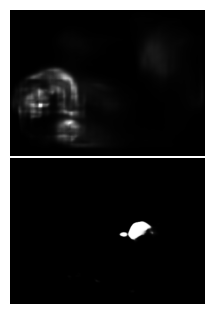

In [33]:
a = 19
# 创建紧凑画布
fig = plt.figure(figsize=(6, 3))

# 使用GridSpec控制微小边距
gs = fig.add_gridspec(2, 1, 
                     hspace=0.02,  # 行间距
                     left=0.01,    # 左边距
                     right=0.99,   # 右边距
                     top=0.99,     # 上边距
                     bottom=0.01)  # 下边距

# 添加图像子图
ax1 = fig.add_subplot(gs[0])
ax1.imshow(imgp[a].reshape(288, 384), 'gray')
ax1.axis('off')
ax1.margins(0.01)  # 图像周围微小边距

ax2 = fig.add_subplot(gs[1])
ax2.imshow(imgp1[a].reshape(288, 384), 'gray')
ax2.axis('off')
ax2.margins(0.01)  # 图像周围微小边距

# 显示紧凑布局
plt.show()